# Upper Confidence Bound BO


In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import torch
import yaml

import matplotlib.pyplot as plt
from xopt import Xopt

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [2]:
# Make a proper input file.
YAML = """
xopt: 
    dump_file: dump.yaml
generator:
  name: upper_confidence_bound
  beta: 0.1

evaluator:
  function: xopt.resources.test_functions.sinusoid_1d.evaluate_sinusoid

vocs:
  variables:
    x1: [0, 6.28]
  objectives:
    y1: 'MINIMIZE'
"""
config = yaml.safe_load(YAML)

In [3]:
X = Xopt(config=config)
X


            Xopt
________________________________
Version: 0+untagged.1.gaab7e5e
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: dump.yaml, max_evaluations: null}
generator:
  name: upper_confidence_bound
  model: null
  turbo_controller: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 2000}
  max_travel_distances: null
  n_monte_carlo_samples: 128
  beta: 0.1
evaluator:
  function: xopt.resources.test_functions.sinusoid_1d.evaluate_sinusoid
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 6.28]
  constraints: {}
  objectives: {y1: MINIMIZE}
  constants: {}
  observables: []


## Run Optimization

In [4]:
X.random_evaluate(3)
for i in range(5):
    print(i)
    X.step()

0
1
2
3
4


## View output data

In [5]:
X.data

,x1,y1,c1,xopt_runtime,xopt_error
1,5.534124,-0.680952,-15.447239,0.000033,False
2,0.997597,0.840170,-0.454084,0.000006,False
3,4.570486,-0.989949,-18.853576,0.000011,False
4,4.240366,-0.890650,-19.393320,0.000019,False
5,4.718340,-0.999982,-18.500690,0.000028,False
6,4.712465,-1.000000,-18.500000,0.000019,False
7,4.710368,-0.999998,-18.500080,0.000019,False
8,4.709235,-0.999995,-18.500194,0.000019,False


## Visualize model used by upper confidence bound
Models are kept in a list, in this case that list has one element, the model
created for the objective `y1`.


Text(0, 0.5, 'y1')

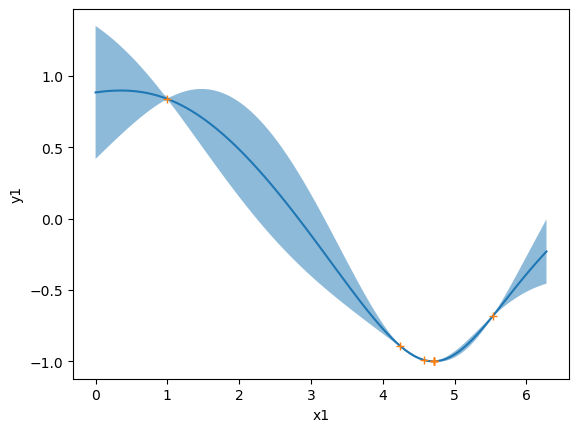

In [6]:
model = X.generator.model
bounds = X.vocs.bounds

test_x = torch.linspace(*bounds.flatten(), 100).double()

train_x = torch.tensor(X.data["x1"].to_numpy())
train_y = torch.tensor(X.data["y1"].to_numpy())

fig, ax = plt.subplots()
with torch.no_grad():
    post = model.models[0].posterior(test_x.reshape(-1,1,1))
    mean = post.mean.flatten()
    std = post.variance.sqrt().flatten()

    lower = mean - std
    upper = mean + std

ax.plot(test_x, mean)
ax.fill_between(test_x, lower, upper, alpha=0.5)
ax.plot(
    train_x.flatten(),
    train_y.flatten(),
    "+"
)
ax.set_xlabel("x1")
ax.set_ylabel("y1")


In [7]:
# Cleanup
!rm dump.yaml